# Import

In [1]:
from transformers import CLIPTextModel, CLIPTokenizer, logging
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, DDIMScheduler, StableDiffusionPipeline
from diffusers.utils.import_utils import is_xformers_available

from torch.cuda.amp import custom_bwd, custom_fwd
from torchvision.utils import save_image
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader

from os.path import isfile
from pathlib import Path
from tqdm.notebook import tqdm

# suppress partial model loading warning
logging.set_verbosity_error()

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np

import matplotlib.pyplot as plt

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(torch.randn(1)) # 1.5410

tensor([1.5410])


## Params

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


In [4]:
# System
fp16 = False
vram_o = True
hf_key = 'runwayml/stable-diffusion-v1-5'
bg_radius = 1.4

# Stable Diffusion
"""key
stabilityai/stable-diffusion-2-1-base
stabilityai/stable-diffusion-2-base
runwayml/stable-diffusion-v1-5
"""
prompt = "a toy"
negative = ''
H = 512
W = 512
steps = 50

# Dataset
radius_range=[3.0, 3.5] # training camera radius range
theta_range=[45, 105] # training camera range along the polar angles (i.e. up and down)
phi_range=[-180, 180] # training camera range along the azimuth angles (i.e. left and right)
angle_overhead=30 # [0, angle_overhead] is the overhead region
angle_front=60 # [0, angle_front] is the front region, [180, 180+angle_front] the back region, otherwise the side region.
uniform_sphere_rate=0.5
known_view_scale=1.5 # multiply --h/w by this for known view rendering
fovy_range=[10, 30] # training camera fovy range
default_polar=90 # polar for the default view
default_azimuth=0 # azimuth for the default view
default_radius=3.2 # radius for the default view
train_batch_size=4
valid_batch_size=1
ds_train_size=100 # 100
ds_valid_size=100 # 100
train_size=ds_train_size*train_batch_size
min_near=0.01

lambda_orient=1e-2
lambda_3d_normal_smooth=0
lambda_2d_normal_smooth=0
lambda_normal=0
upsample_steps=8 #32

# Nerf Network
num_layers=5
hidden_dim=64
num_layers_bg=2
hidden_dim_bg=32
bg_radius=1.4
multires=12
multires_bg=4
blob_density=5
blob_radius=0.2
bound=1
num_steps=16 # 64

# Nerk Network Optimizer
lr=1e-03
wd=5e-4
iters=3000

exp_start_iter=0
exp_end_iter=iters

# Stable Diffusion

In [5]:
def get_perpendicular_component(x, y):
    assert x.shape == y.shape
    return x - ((torch.mul(x, y).sum())/max(torch.norm(y)**2, 1e-6)) * y

def batch_get_perpendicular_component(x, y):
    assert x.shape == y.shape
    result = []
    for i in range(x.shape[0]):
        result.append(get_perpendicular_component(x[i], y[i]))
    return torch.stack(result)

def weighted_perpendicular_aggregator(delta_noise_preds, weights, batch_size):
    """ 
    Notes: 
     - weights: an array with the weights for combining the noise predictions
     - delta_noise_preds: [B x K, 4, 64, 64], K = max_prompts_per_dir
    """
    delta_noise_preds = delta_noise_preds.split(batch_size, dim=0) # K x [B, 4, 64, 64]
    weights = weights.split(batch_size, dim=0) # K x [B]

    assert torch.all(weights[0] == 1.0)

    main_positive = delta_noise_preds[0] # [B, 4, 64, 64]

    accumulated_output = torch.zeros_like(main_positive)
    for i, complementary_noise_pred in enumerate(delta_noise_preds[1:], start=1):
        idx_non_zero = torch.abs(weights[i]) > 1e-4
        if sum(idx_non_zero) == 0:
            continue
        accumulated_output[idx_non_zero] += weights[i][idx_non_zero].reshape(-1, 1, 1, 1) * batch_get_perpendicular_component(complementary_noise_pred[idx_non_zero], main_positive[idx_non_zero])
    
    assert accumulated_output.shape == main_positive.shape, f"{accumulated_output.shape = }, {main_positive.shape = }"

    return accumulated_output + main_positive

In [6]:
class StableDiffusion(nn.Module):
    def __init__(self, device, fp16, vram_o, hf_key='stabilityai/stable-diffusion-2-1-base', t_range=[0.02, 0.98]):
        super().__init__()

        self.device = device

        print(f'[INFO] loading stable diffusion...')

        self.precision_t = torch.float16 if fp16 else torch.float32

        # Create model
        pipe = StableDiffusionPipeline.from_pretrained(hf_key, torch_dtype=self.precision_t)

        if vram_o:
            pipe.enable_sequential_cpu_offload()
            pipe.enable_vae_slicing()
            pipe.unet.to(memory_format=torch.channels_last)
            pipe.enable_attention_slicing(1)
        else:
            pipe.to(device)

        self.vae = pipe.vae
        self.tokenizer = pipe.tokenizer
        self.text_encoder = pipe.text_encoder
        self.unet = pipe.unet

        self.scheduler = DDIMScheduler.from_pretrained(hf_key, subfolder="scheduler", torch_dtype=self.precision_t)

        del pipe

        self.num_train_timesteps = self.scheduler.config.num_train_timesteps
        self.min_step = int(self.num_train_timesteps * t_range[0])
        self.max_step = int(self.num_train_timesteps * t_range[1])
        self.alphas = self.scheduler.alphas_cumprod.to(self.device) # for convenience

        print(f'[INFO] loaded stable diffusion!')

    @torch.no_grad()
    def get_text_embeds(self, prompt: str):

        inputs = self.tokenizer(prompt, padding='max_length', max_length=self.tokenizer.model_max_length, return_tensors='pt')
        embeddings = self.text_encoder(inputs.input_ids.to(self.device))[0]

        return embeddings


    def train_step(self, text_embeddings, pred_rgb, guidance_scale=100, as_latent=False, grad_scale=1, save_guidance_path:Path=None):

        if as_latent:
            latents = F.interpolate(pred_rgb, (64, 64), mode='bilinear', align_corners=False) * 2 - 1
        else:
            # interp to 512x512 to be fed into vae.
            pred_rgb_512 = F.interpolate(pred_rgb, (512, 512), mode='bilinear', align_corners=False)
            # encode image into latents with vae, requires grad!
            latents = self.encode_imgs(pred_rgb_512)

        # timestep ~ U(0.02, 0.98) to avoid very high/low noise level
        t = torch.randint(self.min_step, self.max_step + 1, (latents.shape[0],), dtype=torch.long, device=self.device)

        # predict the noise residual with unet, NO grad!
        with torch.no_grad():
            # add noise
            noise = torch.randn_like(latents)
            latents_noisy = self.scheduler.add_noise(latents, noise, t)
            # pred noise
            latent_model_input = torch.cat([latents_noisy] * 2)
            tt = torch.cat([t] * 2)
            noise_pred = self.unet(latent_model_input, tt, encoder_hidden_states=text_embeddings).sample

            # perform guidance (high scale from paper!)
            noise_pred_uncond, noise_pred_pos = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_pos - noise_pred_uncond)

        # w(t), sigma_t^2
        w = (1 - self.alphas[t])
        grad = grad_scale * w[:, None, None, None] * (noise_pred - noise)
        grad = torch.nan_to_num(grad)

        if save_guidance_path:
            with torch.no_grad():
                if as_latent:
                    pred_rgb_512 = self.decode_latents(latents)

                # visualize predicted denoised image
                # The following block of code is equivalent to `predict_start_from_noise`...
                # see zero123_utils.py's version for a simpler implementation.
                alphas = self.scheduler.alphas.to(latents)
                total_timesteps = self.max_step - self.min_step + 1
                index = total_timesteps - t.to(latents.device) - 1
                b = len(noise_pred)
                a_t = alphas[index].reshape(b,1,1,1).to(self.device)
                sqrt_one_minus_alphas = torch.sqrt(1 - alphas)
                sqrt_one_minus_at = sqrt_one_minus_alphas[index].reshape((b,1,1,1)).to(self.device)
                pred_x0 = (latents_noisy - sqrt_one_minus_at * noise_pred) / a_t.sqrt() # current prediction for x_0
                result_hopefully_less_noisy_image = self.decode_latents(pred_x0.to(latents.type(self.precision_t)))

                # visualize noisier image
                result_noisier_image = self.decode_latents(latents_noisy.to(pred_x0).type(self.precision_t))

                # TODO: also denoise all-the-way

                # all 3 input images are [1, 3, H, W], e.g. [1, 3, 512, 512]
                viz_images = torch.cat([pred_rgb_512, result_noisier_image, result_hopefully_less_noisy_image],dim=0)
                save_image(viz_images, save_guidance_path)

        targets = (latents - grad).detach()
        loss = 0.5 * F.mse_loss(latents.float(), targets, reduction='sum') / latents.shape[0]

        return loss


    def train_step_perpneg(self, text_embeddings, weights, pred_rgb, guidance_scale=100, as_latent=False, grad_scale=1, save_guidance_path:Path=None):

        B = pred_rgb.shape[0]
        K = (text_embeddings.shape[0] // B) - 1 # maximum number of prompts

        if as_latent:
            latents = F.interpolate(pred_rgb, (64, 64), mode='bilinear', align_corners=False) * 2 - 1
        else:
            # interp to 512x512 to be fed into vae.
            pred_rgb_512 = F.interpolate(pred_rgb, (512, 512), mode='bilinear', align_corners=False)
            # encode image into latents with vae, requires grad!
            latents = self.encode_imgs(pred_rgb_512)

        # timestep ~ U(0.02, 0.98) to avoid very high/low noise level
        t = torch.randint(self.min_step, self.max_step + 1, (latents.shape[0],), dtype=torch.long, device=self.device)

        # predict the noise residual with unet, NO grad!
        with torch.no_grad():
            # add noise
            noise = torch.randn_like(latents)
            latents_noisy = self.scheduler.add_noise(latents, noise, t)
            # pred noise
            latent_model_input = torch.cat([latents_noisy] * (1 + K))
            tt = torch.cat([t] * (1 + K))
            unet_output = self.unet(latent_model_input, tt, encoder_hidden_states=text_embeddings).sample

            # perform guidance (high scale from paper!)
            noise_pred_uncond, noise_pred_text = unet_output[:B], unet_output[B:]
            delta_noise_preds = noise_pred_text - noise_pred_uncond.repeat(K, 1, 1, 1)
            noise_pred = noise_pred_uncond + guidance_scale * weighted_perpendicular_aggregator(delta_noise_preds, weights, B)

        # w(t), sigma_t^2
        w = (1 - self.alphas[t])
        grad = grad_scale * w[:, None, None, None] * (noise_pred - noise)
        grad = torch.nan_to_num(grad)

        if save_guidance_path:
            with torch.no_grad():
                if as_latent:
                    pred_rgb_512 = self.decode_latents(latents)

                alphas = self.scheduler.alphas.to(latents)
                total_timesteps = self.max_step - self.min_step + 1
                index = total_timesteps - t.to(latents.device) - 1
                b = len(noise_pred)
                a_t = alphas[index].reshape(b,1,1,1).to(self.device)
                sqrt_one_minus_alphas = torch.sqrt(1 - alphas)
                sqrt_one_minus_at = sqrt_one_minus_alphas[index].reshape((b,1,1,1)).to(self.device)
                pred_x0 = (latents_noisy - sqrt_one_minus_at * noise_pred) / a_t.sqrt() # current prediction for x_0
                result_hopefully_less_noisy_image = self.decode_latents(pred_x0.to(latents.type(self.precision_t)))

                # visualize noisier image
                result_noisier_image = self.decode_latents(latents_noisy.to(pred_x0).type(self.precision_t))

                # all 3 input images are [1, 3, H, W], e.g. [1, 3, 512, 512]
                viz_images = torch.cat([pred_rgb_512, result_noisier_image, result_hopefully_less_noisy_image],dim=0)
                save_image(viz_images, save_guidance_path)

        targets = (latents - grad).detach()
        loss = 0.5 * F.mse_loss(latents.float(), targets, reduction='sum') / latents.shape[0]

        return loss


    @torch.no_grad()
    def produce_latents(self, text_embeddings, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None):

        if latents is None:
            latents = torch.randn((text_embeddings.shape[0] // 2, self.unet.config.in_channels, height // 8, width // 8), device=self.device)

        self.scheduler.set_timesteps(num_inference_steps)

        with tqdm(total=len(range(num_inference_steps))) as pbar:
          for i, t in enumerate(self.scheduler.timesteps):
              # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
              latent_model_input = torch.cat([latents] * 2)
              # predict the noise residual
              noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

              # perform guidance
              noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
              noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

              # compute the previous noisy sample x_t -> x_t-1
              latents = self.scheduler.step(noise_pred, t, latents)['prev_sample']
              pbar.update(1)

        return latents

    def decode_latents(self, latents):

        latents = 1 / self.vae.config.scaling_factor * latents

        imgs = self.vae.decode(latents).sample
        imgs = (imgs / 2 + 0.5).clamp(0, 1)

        return imgs

    def encode_imgs(self, imgs):
        # imgs: [B, 3, H, W]

        imgs = 2 * imgs - 1

        posterior = self.vae.encode(imgs).latent_dist
        latents = posterior.sample() * self.vae.config.scaling_factor

        return latents

    def prompt_to_img(self, prompts, negative_prompts='', height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None):

        if isinstance(prompts, str):
            prompts = [prompts]

        if isinstance(negative_prompts, str):
            negative_prompts = [negative_prompts]

        # Prompts -> text embeds
        pos_embeds = self.get_text_embeds(prompts) # [1, 77, 768]
        neg_embeds = self.get_text_embeds(negative_prompts)
        text_embeds = torch.cat([neg_embeds, pos_embeds], dim=0) # [2, 77, 768]

        # Text embeds -> img latents
        latents = self.produce_latents(text_embeds, height=height, width=width, latents=latents, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale) # [1, 4, 64, 64]

        # Img latents -> imgs
        imgs = self.decode_latents(latents) # [1, 3, 512, 512]

        # Img to Numpy
        imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
        imgs = (imgs * 255).round().astype('uint8')

        return imgs

In [7]:
guidance = StableDiffusion(device=device, fp16=fp16, vram_o=vram_o, hf_key=hf_key)

guidance_total_params = sum(p.numel() for p in guidance.parameters())
print(f"Guidance ToTal Params: {guidance_total_params}")

[INFO] loading stable diffusion...


/media/mountHDD2/git/simple-dream-fusion/.env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[INFO] loaded stable diffusion!
Guidance ToTal Params: 1066235307


  0%|          | 0/50 [00:00<?, ?it/s]

/media/mountHDD2/git/simple-dream-fusion/.env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


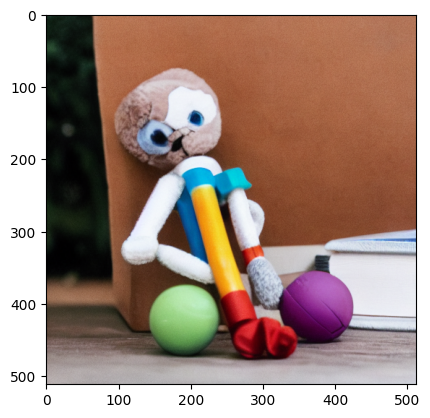

In [8]:
imgs = guidance.prompt_to_img(prompt, negative, H, W, steps)
plt.imshow(imgs[0])
plt.show()

# Nerf

## Model

### Blocks

In [9]:
class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, bias=True):
        super(ResBlock, self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out

        self.dense = nn.Linear(self.dim_in, self.dim_out, bias=bias)
        self.norm = nn.LayerNorm(self.dim_out)
        self.activation = nn.SiLU(inplace=True)

        if self.dim_in != self.dim_out:
            self.skip = nn.Linear(self.dim_in, self.dim_out, bias=False)
        else:
            self.skip = None

    def forward(self, x):
        # x: [B, C]
        identity = x

        out = self.dense(x)
        out = self.norm(out)

        if self.skip is not None:
            identity = self.skip(identity)

        out += identity
        out = self.activation(out)

        return out

class BasicBlock(nn.Module):
    def __init__(self, dim_in, dim_out, bias=True):
        super(BasicBlock, self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out

        self.dense = nn.Linear(self.dim_in, self.dim_out, bias=bias)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        # x: [B, C]

        out = self.dense(x)
        out = self.activation(out)

        return out

class MLP(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, num_layers, bias=True, block=BasicBlock):
        super(MLP, self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_hidden = dim_hidden
        self.num_layers = num_layers

        net = []
        for l in range(num_layers):
            if l == 0:
                net.append(BasicBlock(self.dim_in, self.dim_hidden, bias=bias))
            elif l != num_layers - 1:
                net.append(block(self.dim_hidden, self.dim_hidden, bias=bias))
            else:
                net.append(nn.Linear(self.dim_hidden, self.dim_out, bias=bias))

        self.net = nn.ModuleList(net)


    def forward(self, x):
        for l in range(self.num_layers):
            x = self.net[l](x)

        return x

### Architecture

In [10]:
def near_far_from_bound(rays_o, rays_d, bound, min_near=0.05):
    # rays: [B, N, 3], [B, N, 3]
    # bound: int, radius for ball or half-edge-length for cube
    # return near [B, N, 1], far [B, N, 1]

    radius = rays_o.norm(dim=-1, keepdim=True)

    near = radius - bound # [B, N, 1]
    far = radius + bound

    return near, far

In [11]:
class FreqEncoder(nn.Module):
    def __init__(self, input_dim, max_freq_log2, N_freqs, log_sampling=True, include_input=True):
        super(FreqEncoder, self).__init__()

        self.input_dim = input_dim
        self.include_input = include_input
        self.periodic_fns = (torch.sin, torch.cos)
        self.N_freqs = N_freqs

        self.output_dim = 0
        if self.include_input:
            self.output_dim += self.input_dim

        self.output_dim += self.input_dim * N_freqs * len(self.periodic_fns)

        if log_sampling:
            self.freq_bands = 2 ** torch.linspace(0, max_freq_log2, N_freqs)
        else:
            self.freq_bands = torch.linspace(2 ** 0, 2 ** max_freq_log2, N_freqs)

        self.freq_bands = self.freq_bands.numpy().tolist()

    def forward(self, input):

        max_level = self.N_freqs

        out = []
        if self.include_input:
            out.append(input)

        for i in range(max_level):
            freq = self.freq_bands[i]
            for p_fn in self.periodic_fns:
                out.append(p_fn(input * freq))
        
        out = torch.cat(out, dim=-1)

        return out

In [12]:
class NeRF(nn.Module):
    def __init__(self, num_layers=5, hidden_dim=64, num_layers_bg=2, hidden_dim_bg=32, 
                 bg_radius=1.4, multires=12, multires_bg=4, blob_density=5, blob_radius=0.2, bound=1):
        super(NeRF, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.bg_radius = bg_radius
        self.multires = multires
        self.blob_density = blob_density
        self.blob_radius = blob_radius
        self.bound = bound
        
        self.encoder = FreqEncoder(input_dim=3, max_freq_log2=multires-1, N_freqs=multires)
        self.in_dim = self.encoder.output_dim
        self.sigma_net = MLP(self.in_dim, 4, hidden_dim, num_layers, bias=True, block=ResBlock)

        if self.bg_radius > 0:
            self.num_layers_bg = num_layers_bg   
            self.hidden_dim_bg = hidden_dim_bg
            self.encoder_bg  = FreqEncoder(input_dim=3, max_freq_log2=multires_bg-1, N_freqs=multires_bg)
            self.in_dim_bg = self.encoder_bg.output_dim
            self.bg_net = MLP(self.in_dim_bg, 3, hidden_dim_bg, num_layers_bg, bias=True)
        else:
            self.bg_net = None

        aabb_train = torch.FloatTensor([-self.bound, -self.bound, -self.bound, self.bound, self.bound, self.bound])
        aabb_infer = aabb_train.clone()
        self.register_buffer('aabb_train', aabb_train)
        self.register_buffer('aabb_infer', aabb_infer)

    def common_forward(self, x):
        # x: [N, 3], in [-bound, bound] # [-1, 1]

        # sigma
        enc = self.encoder(x)

        h = self.sigma_net(enc)

        sigma = F.softplus(h[..., 0] + self.density_blob(x))
        albedo = torch.sigmoid(h[..., 1:])

        return sigma, albedo

    def forward(self, x, d, l=None, ratio=1, shading='albedo'):
        # x: [N, 3], in [-bound, bound]
        # d: [N, 3], view direction, nomalized in [-1, 1]
        # l: [3], plane light direction, nomalized in [-1, 1]
        # ratio: scalar, ambient ratio, 1 == no shading (albedo only), 0 == only shading (textureless)

        if shading == 'albedo':
            # no need to query normal
            sigma, color = self.common_forward(x)
            normal = None
        
        else:
            with torch.enable_grad():
                with torch.cuda.amp.autocast(enabled=False):
                    x.requires_grad_(True)
                    sigma, albedo = self.common_forward(x)
                    # query gradient
                    normal = - torch.autograd.grad(torch.sum(sigma), x, create_graph=True)[0] # [N, 3]
            normal = safe_normalize(normal)
            normal = torch.nan_to_num(normal)

            # lambertian shading
            lambertian = ratio + (1 - ratio) * (normal * l).sum(-1).clamp(min=0) # [N,]

            if shading == 'textureless':
                color = lambertian.unsqueeze(-1).repeat(1, 3)
            elif shading == 'normal':
                color = (normal + 1) / 2
            else: # 'lambertian'
                color = albedo * lambertian.unsqueeze(-1)
            
        return sigma, color, normal

    @torch.no_grad()
    def density_blob(self, x):
        # x: [B, N, 3]
        
        d = (x ** 2).sum(-1)
        
        g = self.blob_density * torch.exp(- d / (2 * self.blob_radius ** 2))

        return g
        
    def density(self, x):
        # x: [N, 3], in [-bound, bound]
        
        sigma, albedo = self.common_forward(x)
        
        return {'sigma': sigma, 'albedo': albedo}

    def background(self, d):

        h = self.encoder_bg(d) # [N, C]
        
        h = self.bg_net(h)

        # sigmoid activation for rgb
        rgbs = torch.sigmoid(h)

        return rgbs

    def render(self, rays_o, rays_d, bg_color, ambient_ratio, shading, binarize):
        # rays_o, rays_d: [B, N, 3]
        # bg_color: [BN, 3] in range [0, 1]
        # return: image: [B, N, 3], depth: [B, N]

        prefix = rays_o.shape[:-1]
        rays_o = rays_o.contiguous().view(-1, 3)
        rays_d = rays_d.contiguous().view(-1, 3)

        N = rays_o.shape[0] # N = B * N, in fact
        device = rays_o.device

        results = {}

        # choose aabb
        aabb = self.aabb_train if self.training else self.aabb_infer

        nears, fars = near_far_from_bound(rays_o, rays_d, self.bound, min_near=min_near)

        # gaussian noise around the ray origin, so the light always face the view dir (avoid dark face)
        light_d = safe_normalize(rays_o + torch.randn(3, device=rays_o.device)) # [N, 3]

        z_vals = torch.linspace(0.0, 1.0, num_steps, device=device).unsqueeze(0) # [1, T]
        z_vals = z_vals.expand((N, num_steps)) # [N, T]
        z_vals = nears + (fars - nears) * z_vals # [N, T], in [nears, fars]

        sample_dist = (fars - nears) / num_steps
        z_vals = z_vals + (torch.rand(z_vals.shape, device=device) - 0.5) * sample_dist

        xyzs = rays_o.unsqueeze(-2) + rays_d.unsqueeze(-2) * z_vals.unsqueeze(-1) # [N, 1, 3] * [N, T, 1] -> [N, T, 3]
        xyzs = torch.min(torch.max(xyzs, aabb[:3]), aabb[3:]) # a manual clip.

        # query SDF and RGB
        density_outputs = self.density(xyzs.reshape(-1, 3))

        for k, v in density_outputs.items():
            density_outputs[k] = v.view(N, num_steps, -1)

        with torch.no_grad():
            deltas = z_vals[..., 1:] - z_vals[..., :-1] # [N, T-1]
            deltas = torch.cat([deltas, sample_dist * torch.ones_like(deltas[..., :1])], dim=-1)

            alphas = 1 - torch.exp(-deltas * density_outputs['sigma'].squeeze(-1)) # [N, T]
            alphas_shifted = torch.cat([torch.ones_like(alphas[..., :1]), 1 - alphas + 1e-15], dim=-1) # [N, T+1]
            weights = alphas * torch.cumprod(alphas_shifted, dim=-1)[..., :-1] # [N, T]

            # sample new z_vals
            z_vals_mid = (z_vals[..., :-1] + 0.5 * deltas[..., :-1]) # [N, T-1]
            new_z_vals = sample_pdf(z_vals_mid, weights[:, 1:-1], upsample_steps, det=not self.training).detach() # [N, t]

            new_xyzs = rays_o.unsqueeze(-2) + rays_d.unsqueeze(-2) * new_z_vals.unsqueeze(-1) # [N, 1, 3] * [N, t, 1] -> [N, t, 3]
            new_xyzs = torch.min(torch.max(new_xyzs, aabb[:3]), aabb[3:]) # a manual clip.

        # only forward new points to save computation
        new_density_outputs = self.density(new_xyzs.reshape(-1, 3))
        #new_sigmas = new_density_outputs['sigma'].view(N, self.opt.upsample_steps) # [N, t]
        for k, v in new_density_outputs.items():
            new_density_outputs[k] = v.view(N, upsample_steps, -1)

        # re-order - straitify sampling??
        z_vals = torch.cat([z_vals, new_z_vals], dim=1) # [N, T+t]
        z_vals, z_index = torch.sort(z_vals, dim=1)

        xyzs = torch.cat([xyzs, new_xyzs], dim=1) # [N, T+t, 3]
        xyzs = torch.gather(xyzs, dim=1, index=z_index.unsqueeze(-1).expand_as(xyzs))

        for k in density_outputs:
            tmp_output = torch.cat([density_outputs[k], new_density_outputs[k]], dim=1)
            density_outputs[k] = torch.gather(tmp_output, dim=1, index=z_index.unsqueeze(-1).expand_as(tmp_output))

        deltas = z_vals[..., 1:] - z_vals[..., :-1] # [N, T+t-1]
        deltas = torch.cat([deltas, sample_dist * torch.ones_like(deltas[..., :1])], dim=-1)
        alphas = 1 - torch.exp(-deltas * density_outputs['sigma'].squeeze(-1)) # [N, T+t]
        alphas_shifted = torch.cat([torch.ones_like(alphas[..., :1]), 1 - alphas + 1e-15], dim=-1) # [N, T+t+1]
        weights = alphas * torch.cumprod(alphas_shifted, dim=-1)[..., :-1] # [N, T+t]

        dirs = rays_d.view(-1, 1, 3).expand_as(xyzs)
        light_d = light_d.view(-1, 1, 3).expand_as(xyzs)
        for k, v in density_outputs.items():
            density_outputs[k] = v.view(-1, v.shape[-1])

        dirs = safe_normalize(dirs)
        sigmas, rgbs, normals = self(xyzs.reshape(-1, 3), dirs.reshape(-1, 3), light_d.reshape(-1, 3), ratio=ambient_ratio, shading=shading)
        rgbs = rgbs.view(N, -1, 3) # [N, T+t, 3]
        if normals is not None:
            normals = normals.view(N, -1, 3)

        # calculate weight_sum (mask)
        weights_sum = weights.sum(dim=-1) # [N]
        
        # calculate depth 
        depth = torch.sum(weights * z_vals, dim=-1)

        # calculate color
        image = torch.sum(weights.unsqueeze(-1) * rgbs, dim=-2) # [N, 3], in [0, 1]

        if bg_color is None:
            if bg_radius > 0:
                # use the bg model to calculate bg_color
                bg_color = self.background(rays_d) # [N, 3]
            else:
                bg_color = 1

        image = image + (1 - weights_sum).unsqueeze(-1) * bg_color

        image = image.view(*prefix, 3)
        depth = depth.view(*prefix)
        weights_sum = weights_sum.reshape(*prefix)

        if self.training:
            if lambda_orient > 0 and normals is not None:
                # orientation loss
                loss_orient = weights.detach() * (normals * dirs).sum(-1).clamp(min=0) ** 2
                results['loss_orient'] = loss_orient.sum(-1).mean()
            
            if lambda_3d_normal_smooth > 0 and normals is not None:
                normals_perturb = self.normal(xyzs + torch.randn_like(xyzs) * 1e-2)
                results['loss_normal_perturb'] = (normals - normals_perturb).abs().mean()
            
            if (lambda_2d_normal_smooth > 0 or lambda_normal > 0) and normals is not None:
                normal_image = torch.sum(weights.unsqueeze(-1) * (normals + 1) / 2, dim=-2) # [N, 3], in [0, 1]
                results['normal_image'] = normal_image
        
        results['image'] = image
        results['depth'] = depth
        results['weights'] = weights
        results['weights_sum'] = weights_sum

        return results

### Dataset

In [13]:
def safe_normalize(x, eps=1e-20):
    return x / torch.sqrt(torch.clamp(torch.sum(x * x, -1, keepdim=True), min=eps))

In [14]:
def rand_poses(size, device, radius_range=[1, 1.5], theta_range=[0, 120], phi_range=[0, 360], 
               angle_overhead=30, angle_front=60, uniform_sphere_rate=0.5):
    
    theta_range = np.array(theta_range) / 180 * np.pi
    phi_range = np.array(phi_range) / 180 * np.pi
    angle_overhead = angle_overhead / 180 * np.pi
    angle_front = angle_front / 180 * np.pi

    radius = torch.rand(size, device=device) * (radius_range[1] - radius_range[0]) + radius_range[0]

    if random.random() < uniform_sphere_rate:
        unit_centers = F.normalize(
            torch.stack([
                torch.randn(size, device=device),
                torch.abs(torch.randn(size, device=device)),
                torch.randn(size, device=device),
            ], dim=-1), p=2, dim=1
        )
        thetas = torch.acos(unit_centers[:,1])
        phis = torch.atan2(unit_centers[:,0], unit_centers[:,2])
        phis[phis < 0] += 2 * np.pi
        centers = unit_centers * radius.unsqueeze(-1)
    else:
        thetas = torch.rand(size, device=device) * (theta_range[1] - theta_range[0]) + theta_range[0]
        phis = torch.rand(size, device=device) * (phi_range[1] - phi_range[0]) + phi_range[0]
        phis[phis < 0] += 2 * np.pi

        centers = torch.stack([
            radius * torch.sin(thetas) * torch.sin(phis),
            radius * torch.cos(thetas),
            radius * torch.sin(thetas) * torch.cos(phis),
        ], dim=-1) # [B, 3]

    targets = 0

    forward_vector = safe_normalize(centers - targets)
    up_vector = torch.FloatTensor([0, 1, 0]).to(device).unsqueeze(0).repeat(size, 1)
    right_vector = safe_normalize(torch.cross(forward_vector, up_vector, dim=-1))

    up_vector = safe_normalize(torch.cross(right_vector, forward_vector, dim=-1))

    poses = torch.eye(4, dtype=torch.float, device=device).unsqueeze(0).repeat(size, 1, 1)
    poses[:, :3, :3] = torch.stack((right_vector, up_vector, forward_vector), dim=-1)
    poses[:, :3, 3] = centers

    thetas = thetas / np.pi * 180
    phis = phis / np.pi * 180

    return poses, thetas, phis, radius

In [15]:
def get_rays(poses, intrinsics, H, W):

    device = poses.device
    B = poses.shape[0]
    fx, fy, cx, cy = intrinsics

    i, j = torch.meshgrid(torch.linspace(0, W-1, W, device=device), torch.linspace(0, H-1, H, device=device), indexing='ij')
    i = i.t().reshape([1, H*W]).expand([B, H*W]) + 0.5
    j = j.t().reshape([1, H*W]).expand([B, H*W]) + 0.5

    results = {}
    
    inds = torch.arange(H*W, device=device).expand([B, H*W])

    zs = - torch.ones_like(i)
    xs = - (i - cx) / fx * zs
    ys = (j - cy) / fy * zs
    directions = torch.stack((xs, ys, zs), dim=-1)
    # directions = safe_normalize(directions)
    rays_d = directions @ poses[:, :3, :3].transpose(-1, -2) # (B, N, 3)

    rays_o = poses[..., :3, 3] # [B, 3]
    rays_o = rays_o[..., None, :].expand_as(rays_d) # [B, N, 3]

    results['rays_o'] = rays_o
    results['rays_d'] = rays_d

    return results

In [16]:
class NeRFDataset:
    def __init__(self, device, size=100):

        self.known_view_scale = known_view_scale
        self.device = device

        self.H = H
        self.W = W
        self.size = size

        self.cx = self.H / 2
        self.cy = self.W / 2

        self.near = min_near
        self.far = 1000 # infinite

    def collate(self, index):
        
        B = len(index)

        # random pose on the fly
        poses, thetas, phis, radius = rand_poses(
            B, self.device, radius_range=radius_range, theta_range=theta_range, phi_range=phi_range, 
            angle_overhead=angle_overhead, angle_front=angle_front, uniform_sphere_rate=uniform_sphere_rate
        )

        # random focal
        fov = random.random() * (fovy_range[1] - fovy_range[0]) + fovy_range[0]

        focal = self.H / (2 * np.tan(np.deg2rad(fov) / 2))
        intrinsics = np.array([focal, focal, self.cx, self.cy])

        projection = torch.tensor([
            [2*focal/self.W, 0, 0, 0],
            [0, -2*focal/self.H, 0, 0],
            [0, 0, -(self.far+self.near)/(self.far-self.near), -(2*self.far*self.near)/(self.far-self.near)],
            [0, 0, -1, 0]
        ], dtype=torch.float32, device=self.device).unsqueeze(0)

        mvp = projection @ torch.inverse(poses) # [1, 4, 4] # map 3D to 2D

        # sample a low-resolution but full image
        rays = get_rays(poses, intrinsics, self.H, self.W)

        # delta polar/azimuth/radius to default view
        delta_polar = thetas - default_polar
        delta_azimuth = phis - default_azimuth
        delta_azimuth[delta_azimuth > 180] -= 360 # range in [-180, 180]
        delta_radius = radius - default_radius

        data = {
            'H': self.H,
            'W': self.W,
            'rays_o': rays['rays_o'],
            'rays_d': rays['rays_d'],
            # 'dir': dirs,
            'mvp': mvp,
            'polar': delta_polar,
            'azimuth': delta_azimuth,
            'radius': delta_radius,
        }

        return data

    def dataloader(self, batch_size):
        loader = DataLoader(list(range(self.size)), batch_size=batch_size, collate_fn=self.collate, shuffle=True, num_workers=0)
        loader._data = self
        return loader

# Train

## Model Setup

In [17]:
model = NeRF(num_layers=num_layers, hidden_dim=hidden_dim, num_layers_bg=num_layers_bg, 
             hidden_dim_bg=hidden_dim_bg, bg_radius=bg_radius, multires=multires, multires_bg=multires_bg, 
             blob_density=blob_density, blob_radius=blob_radius, bound=bound).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total Nerf Params: {total_params}")

Total Nerf Params: 18983


In [18]:
for p in guidance.parameters():
    p.requires_grad = False

In [19]:
optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)

## Data

In [20]:
train_loader = NeRFDataset(device=device, size=train_size).dataloader(batch_size=train_batch_size)
epochs=iters//len(train_loader)

## Overfitting Training

### Embedding

In [21]:
text_emb = guidance.get_text_embeds([prompt])
neg_text_emb = guidance.get_text_embeds([negative])

front_text_emb = guidance.get_text_embeds([f"{prompt}, front view"])
side_text_emb = guidance.get_text_embeds([f"{prompt}, side view"])
back_text_emb = guidance.get_text_embeds([f"{prompt}, back view"])

### Fitting

In [22]:
for epoch in range(epochs):
    model.train()

    total_loss = 0
    local_step = 0
    global_step = 0

    for data in tqdm(train_loader):
        optimizer.zero_grad()

        rays_o = data['rays_o'] # [B, N, 3]
        rays_d = data['rays_d'] # [B, N, 3]
        mvp = data['mvp'] # [B, 4, 4]

        B, N = rays_o.shape[:2]
        _H, _W = data['H'], data['W']

        exp_iter_ratio = (global_step - exp_start_iter) / (exp_end_iter - exp_start_iter)

        if B > train_batch_size:
            choice = torch.randperm(B)[:self.opt.batch_size]
            B = batch_size
            rays_o = rays_o[choice]
            rays_d = rays_d[choice]
            mvp = mvp[choice]

        ambient_ratio = 1.0
        shading = 'normal'
        as_latent = True
        binarize = False
        bg_color = None

        outputs = model.render(rays_o, rays_d, bg_color, ambient_ratio, shading, binarize)
        pred_depth = outputs['depth'].reshape(B, 1, _H, _W)
        pred_mask = outputs['weights_sum'].reshape(B, 1, _H, _W)

        print(pred_depth.shape, pred_depth.min(), pred_depth.max())
        print(pred_mask.shape, pred_mask.min(), pred_mask.max())

        break

  0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 